<a href="https://colab.research.google.com/github/fazaghifari/Notebook-Collections/blob/master/computervision/cifar10_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple implementation of CNN on CIFAR-10
---
In this notebook, a simple CNN without transfer learning is implemented to classify images based on CIFAR-10 dataset.

CIFAR-10 dataset consists of small color images that fall into one of ten classes; some example images are pictured below.

<img src='https://storage.googleapis.com/kaggle-competitions/kaggle/3649/media/cifar-10.png' width=50% height=50% />

### Check [CUDA](http://pytorch.org/docs/stable/cuda.html)

Check if GPU is available

In [1]:
import tensorflow as tf
import numpy as np

# Check on versioning and gpu usage
print(f"TensorFlow version\t: {tf.__version__}")
print(f"GPU check\t: {tf.test.gpu_device_name()}")

# Check on what GPU we use
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

TensorFlow version	: 2.2.0
GPU check	: /device:GPU:0


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 18023101625890697447, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 2166277821714913940
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 12602909666557673999
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14648777152
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 2727649399400354147
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

---
## Load the [Data](http://pytorch.org/docs/stable/torchvision/datasets.html)

Downloading may take a minute. We load in the training and test data, split the training data into a training and validation set, then create DataLoaders for each of these sets of data.

In [0]:
cifar10 = tf.keras.datasets.cifar10
(training_images, training_labels), (test_images, test_labels) = cifar10.load_data()

### Visualize a Batch of Training Data

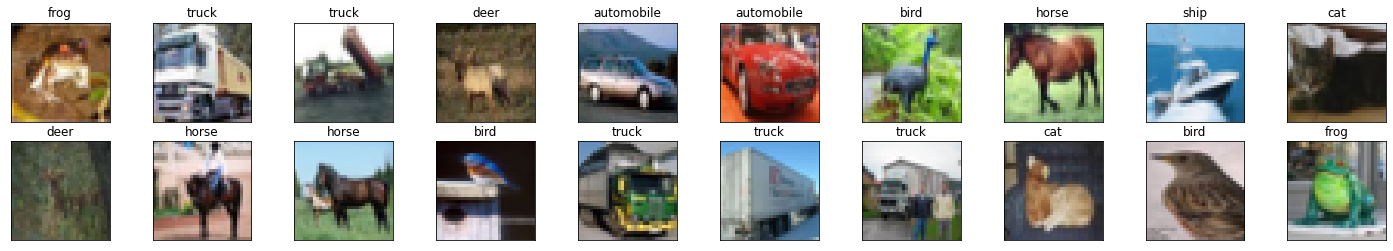

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(training_images[idx])
    ax.set_title(classes[training_labels[idx,:][0]])

### Data generator

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
num_classes = 10
train_batch_size = 50
val_batch_size = 20
train_datagen = ImageDataGenerator(rescale=1./255,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
validation_datagen = ImageDataGenerator(rescale=1./255,
      fill_mode='nearest')

training_labels = to_categorical(training_labels,num_classes)
test_labels = to_categorical(test_labels,num_classes)

train_generator = train_datagen.flow(training_images, training_labels, batch_size=train_batch_size)
val_generator = validation_datagen.flow(test_images, test_labels, batch_size=val_batch_size)

(50, 10)


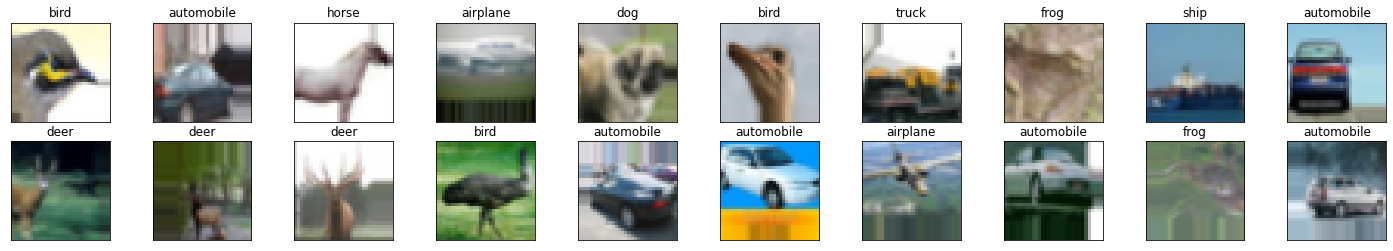

In [5]:
x_batch, y_batch = next(train_generator)
print(y_batch.shape)
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    image = x_batch[idx]
    plt.imshow(image)
    ax.set_title(classes[np.where(y_batch[idx,:] == 1)[0][0]])

---
## Define the Network [Architecture](http://pytorch.org/docs/stable/nn.html)

High accuracy on CIFAR-10 can be obtained through transfer learning process since a lot of pre-trained models are quite big and have been trained on more sophisticated dataset. However, since we are not using any kind of pre-trained model, we have to define our model. There are 5 main components in this network namely: 

*   Convolutional layer (Conv2d)
*   Max Pooling layer (MaxPool2d)
*   Batch Normalization (BatchNorm2d)
*   Dropout Layer (Dropout)
*   Dense Layer (Linear)

The convolutional layer gradually increase the number of features from 3 to 256 with `padding = 1` which keeps the size of the image through the convolutional layers. Meanwhile, the size of the image is gradually reduced from 32 x 32 into 4 x 4 by using the max pooling layer.

In [6]:
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers

weight_decay = 1e-4
model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', input_shape=(32,32,3) ))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(32, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
 
model.add(Conv2D(64, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
 
model.add(Conv2D(128, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(128, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
 
model.add(Flatten())
model.add(Dense(10, activation='softmax'))
 

model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0

---
## Train the Network

In [0]:
class mycallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') >= 0.9 and epoch > 10:
            print('Accuracy threshold passed, stopping training')
            self.model.stop_training = True

callbacks = mycallback()

In [8]:
steps = int(training_images.shape[0] / train_batch_size)
val_steps = int(test_images.shape[0] / val_batch_size)
history = model.fit(train_generator, epochs=50, steps_per_epoch=steps, validation_steps=val_steps, verbose=1, validation_data=val_generator, callbacks=[callbacks])

Epoch 1/50
1000/1000 [==============================] - 29s 29ms/step - loss: 1.7272 - accuracy: 0.3839 - val_loss: 1.6271 - val_accuracy: 0.4387
Epoch 2/50
1000/1000 [==============================] - 29s 29ms/step - loss: 1.3094 - accuracy: 0.5301 - val_loss: 2.1049 - val_accuracy: 0.3918
Epoch 3/50
1000/1000 [==============================] - 29s 29ms/step - loss: 1.1195 - accuracy: 0.6023 - val_loss: 1.4625 - val_accuracy: 0.5474
Epoch 4/50
1000/1000 [==============================] - 30s 30ms/step - loss: 1.0004 - accuracy: 0.6474 - val_loss: 1.2188 - val_accuracy: 0.6019
Epoch 5/50
1000/1000 [==============================] - 29s 29ms/step - loss: 0.9167 - accuracy: 0.6803 - val_loss: 0.9295 - val_accuracy: 0.6934
Epoch 6/50
1000/1000 [==============================] - 29s 29ms/step - loss: 0.8547 - accuracy: 0.7016 - val_loss: 1.3156 - val_accuracy: 0.5986
Epoch 7/50
1000/1000 [==============================] - 29s 29ms/step - loss: 0.8050 - accuracy: 0.7197 - val_loss: 0.8476 -

### Plot Loss and Accuracy

<Figure size 432x288 with 0 Axes>

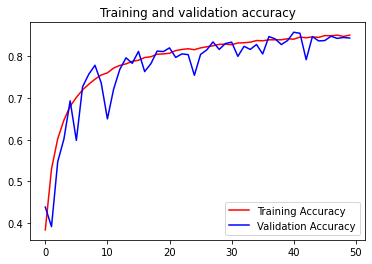

<Figure size 432x288 with 0 Axes>

In [12]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', label= "Training Accuracy")
plt.plot(epochs, val_acc, 'b', label= "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

<Figure size 432x288 with 0 Axes>

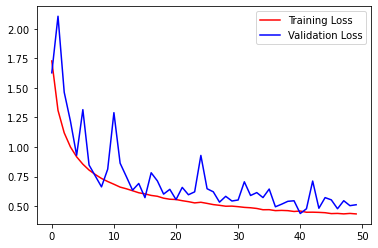

<Figure size 432x288 with 0 Axes>

In [13]:
#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.legend()
plt.figure()

---
## Test the Trained Network

Test your trained model on previously unseen data! A "good" result will be a CNN that gets around 70% (or more, try your best!) accuracy on these test images.

In [37]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

# iterate over test data
output = model.predict(test_images/255)
# convert output probabilities to predicted class
pred = np.argmax(output, 1)
print(pred[:20])
ground_truth = np.argmax(test_labels, 1)
print(ground_truth[:20])
# compare predictions to true label
correct = pred == ground_truth
print(correct[:20])
# calculate test accuracy for each object class
for i in range(len(test_images)):
    label = int(ground_truth[i])
    class_correct[label] += correct[i]
    class_total[label] += 1

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.mean(correct),
    np.sum(class_correct), np.sum(class_total)))

[3 8 8 8 6 6 1 6 3 1 0 9 6 7 9 8 5 9 8 6]
[3 8 8 0 6 6 1 6 3 1 0 9 5 7 9 8 5 7 8 6]
[ True  True  True False  True  True  True  True  True  True  True  True
 False  True  True  True  True False  True  True]
Test Accuracy of airplane: 81% (816/1000)
Test Accuracy of automobile: 97% (975/1000)
Test Accuracy of  bird: 73% (737/1000)
Test Accuracy of   cat: 71% (716/1000)
Test Accuracy of  deer: 76% (765/1000)
Test Accuracy of   dog: 78% (786/1000)
Test Accuracy of  frog: 96% (969/1000)
Test Accuracy of horse: 85% (856/1000)
Test Accuracy of  ship: 88% (882/1000)
Test Accuracy of truck: 93% (938/1000)

Test Accuracy (Overall): 84% (8440/10000)
